# Traffic Control Scenario Comparison - E0 to E3 Section

Comprehensive comparison of four traffic control strategies on the **E0-E3 corridor**:
- **Baseline**: Original network with fixed timing
- **Actuated**: Actuated traffic control
- **Max Pressure**: Max Pressure traffic control
- **RL**: Reinforcement Learning traffic control

This analysis focuses on **directional performance** comparing:
- **Direction A (E0→E3)**: Forward direction
- **Direction B (E3→E0)**: Backward direction

**Metrics analyzed:**
- Speed in both directions
- Accumulated waiting times in both directions
- Average bus trip waiting times in both directions
- Average trip duration in both directions

**Output**: Results saved to `Scenario comparison results/`

In [1]:
# ==========================================
# 1. IMPORTS AND CONFIGURATION
# ==========================================
import os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from math import pi

# Set up plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Define paths
BASE_DIR = os.getcwd()
OUTPUT_DIR = os.path.join(BASE_DIR, 'Scenario comparison results')

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Define scenario paths
SCENARIOS = {
    'Baseline': os.path.join(BASE_DIR, 'Original network'),
    'Actuated': os.path.join(BASE_DIR, 'Network with actuated control'),
    'Max Pressure': os.path.join(BASE_DIR, 'Network with max pressure control'),
    'RL': os.path.join(BASE_DIR, 'Network with RL control')
}

# Define the E0-E3 section edges
DIR_A_EDGES = ["E0E1", "E1E2", "E2E3"]  # Forward (E0 -> E3)
DIR_B_EDGES = ["E3E2", "E2E1", "E1E0"]  # Backward (E3 -> E0)
ALL_SECTION_EDGES = DIR_A_EDGES + DIR_B_EDGES

print("="*80)
print("SCENARIO COMPARISON CONFIGURATION - E0 to E3 Section")
print("="*80)
print(f"Output directory: {OUTPUT_DIR}")
print(f"\nDirection A (E0→E3): {', '.join(DIR_A_EDGES)}")
print(f"Direction B (E3→E0): {', '.join(DIR_B_EDGES)}")
print(f"\nScenario paths:")
for name, path in SCENARIOS.items():
    results_exists = os.path.exists(os.path.join(path, 'results'))
    print(f"  {name:15s}: {results_exists} - {path}")
print("="*80)

SCENARIO COMPARISON CONFIGURATION - E0 to E3 Section
Output directory: c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Scenario comparison results

Direction A (E0→E3): E0E1, E1E2, E2E3
Direction B (E3→E0): E3E2, E2E1, E1E0

Scenario paths:
  Baseline       : True - c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Original network
  Actuated       : True - c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Network with actuated control
  Max Pressure   : True - c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Network with max pressure control
  RL            

In [4]:
# ==========================================
# 2. DATA LOADING AND PARSING
# ==========================================
import shutil

def classify_vehicle(veh_id):
    """Classify vehicles based on their ID prefix."""
    prefix = veh_id.split('.')[0] if '.' in veh_id else veh_id
    
    # --- Direction A (E0 -> E3) ---
    if prefix in ['f_7']: 
        return "Bus", "Dir A"
    
    # --- Direction B (E3 -> E0) ---
    elif prefix in ['f_6']: 
        return "Bus", "Dir B"
        
    # --- Other categories ---
    elif prefix in ['f_4', 'f_5']:
        return "Bus", "Other"
    elif prefix in ['f_0', 'f_1', 'f_2', 'f_3']:
        return "Car", "Transversal"
    else:
        return "Car", "Other"

def get_vehicle_direction(trip, veh_id):
    """Determine vehicle direction based on vehicle ID classification."""
    prefix = veh_id.split('.')[0] if '.' in veh_id else veh_id
    
    # --- Direction A (E0 -> E3) ---
    if prefix in ['f_7']: 
        return "Dir A"
    
    # --- Direction B (E3 -> E0) ---
    elif prefix in ['f_6']: 
        return "Dir B"
    
    return None  # Not on our section

def ensure_tripinfo_exists(scenario_path, scenario_name):
    """
    Ensure tripinfo.xml exists in results folder.
    If not, try to find it in parent directory or use alternative names.
    Returns the path to tripinfo.xml if found/created, None otherwise.
    """
    results_dir = os.path.join(scenario_path, 'results')
    tripinfo_path = os.path.join(results_dir, 'tripinfo.xml')
    
    # Create results directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    
    # For RL scenario, prefer tripinfo_eval_ep999.xml (evaluation results)
    if scenario_name == 'RL':
        eval_tripinfo = os.path.join(results_dir, 'tripinfo_eval_ep999.xml')
        if os.path.exists(eval_tripinfo):
            print(f"  → Using {os.path.basename(eval_tripinfo)} for RL scenario")
            # If corrupted tripinfo.xml exists, remove it first
            if os.path.exists(tripinfo_path):
                try:
                    os.remove(tripinfo_path)
                    print(f"  → Removed corrupted tripinfo.xml")
                except:
                    pass
            shutil.copy(eval_tripinfo, tripinfo_path)
            return tripinfo_path
    
    # Check if tripinfo.xml already exists in results/
    if os.path.exists(tripinfo_path):
        # Verify it's valid XML
        try:
            tree = ET.parse(tripinfo_path)
            return tripinfo_path
        except ET.ParseError:
            print(f"  ⚠ Existing tripinfo.xml is corrupted, looking for alternatives...")
            # Try to remove corrupted file
            try:
                os.remove(tripinfo_path)
            except:
                pass
    
    # Check if tripinfo.xml exists in parent directory (scenario root)
    parent_tripinfo = os.path.join(scenario_path, 'tripinfo.xml')
    if os.path.exists(parent_tripinfo):
        print(f"  → Copying tripinfo.xml from scenario root to results/")
        shutil.copy(parent_tripinfo, tripinfo_path)
        return tripinfo_path
    
    return None

def parse_tripinfo(tripinfo_path):
    """
    Parse tripinfo XML file and extract KPIs for E0-E3 section.
    Returns: (metrics_dict, dataframe) or None if file doesn't exist or is corrupted
    """
    if not os.path.exists(tripinfo_path):
        return None
    
    try:
        tree = ET.parse(tripinfo_path)
        root = tree.getroot()
        
        trips = []
        for tripinfo in root.findall('tripinfo'):
            veh_id = tripinfo.get('id')
            direction = get_vehicle_direction(tripinfo, veh_id)
            
            # Only include vehicles on our E0-E3 section
            if direction is None:
                continue
            
            veh_type, veh_dir_class = classify_vehicle(veh_id)
            
            # Use route-based direction if classification doesn't provide it
            if veh_dir_class not in ["Dir A", "Dir B"]:
                veh_dir_class = direction
            
            trip = {
                'id': veh_id,
                'duration': float(tripinfo.get('duration')),
                'waitingTime': float(tripinfo.get('waitingTime')),
                'timeLoss': float(tripinfo.get('timeLoss')),
                'routeLength': float(tripinfo.get('routeLength')),
                'departSpeed': float(tripinfo.get('departSpeed')),
                'arrivalSpeed': float(tripinfo.get('arrivalSpeed')),
                'vehicle_type': veh_type,
                'direction': veh_dir_class
            }
            trips.append(trip)
        
        if not trips:
            return None
        
        df = pd.DataFrame(trips)
        
        # Calculate directional metrics
        dir_a_df = df[df['direction'] == 'Dir A']
        dir_b_df = df[df['direction'] == 'Dir B']
        
        # Bus-specific dataframes
        bus_dir_a = df[(df['vehicle_type'] == 'Bus') & (df['direction'] == 'Dir A')]
        bus_dir_b = df[(df['vehicle_type'] == 'Bus') & (df['direction'] == 'Dir B')]
        
        metrics = {
            'total_vehicles': len(df),
            'dir_a_vehicles': len(dir_a_df),
            'dir_b_vehicles': len(dir_b_df),
            'bus_dir_a_vehicles': len(bus_dir_a),
            'bus_dir_b_vehicles': len(bus_dir_b),
            
            # Direction A metrics
            'dir_a_avg_speed': dir_a_df['arrivalSpeed'].mean() if len(dir_a_df) > 0 else 0,
            'dir_a_total_waiting': dir_a_df['waitingTime'].sum() if len(dir_a_df) > 0 else 0,
            'dir_a_avg_duration': dir_a_df['duration'].mean() if len(dir_a_df) > 0 else 0,
            'dir_a_bus_avg_waiting': bus_dir_a['waitingTime'].mean() if len(bus_dir_a) > 0 else 0,
            'dir_a_bus_avg_duration': bus_dir_a['duration'].mean() if len(bus_dir_a) > 0 else 0,
            
            # Direction B metrics
            'dir_b_avg_speed': dir_b_df['arrivalSpeed'].mean() if len(dir_b_df) > 0 else 0,
            'dir_b_total_waiting': dir_b_df['waitingTime'].sum() if len(dir_b_df) > 0 else 0,
            'dir_b_avg_duration': dir_b_df['duration'].mean() if len(dir_b_df) > 0 else 0,
            'dir_b_bus_avg_waiting': bus_dir_b['waitingTime'].mean() if len(bus_dir_b) > 0 else 0,
            'dir_b_bus_avg_duration': bus_dir_b['duration'].mean() if len(bus_dir_b) > 0 else 0,
        }
        
        return metrics, df
    
    except ET.ParseError as e:
        print(f"  ⚠ XML Parse Error: {e}")
        return None
    except Exception as e:
        print(f"  ⚠ Error: {e}")
        return None

# Parse all scenarios
print("\nLoading scenario data (E0-E3 section only)...")
results_data = {}
for scenario_name, scenario_path in SCENARIOS.items():
    print(f"\n{scenario_name}:")
    
    # Ensure tripinfo.xml exists in results folder
    tripinfo_path = ensure_tripinfo_exists(scenario_path, scenario_name)
    
    if tripinfo_path is None:
        print(f"  ✗ tripinfo.xml not found")
        continue
    
    # Parse the file
    result = parse_tripinfo(tripinfo_path)
    if result:
        metrics, df = result
        results_data[scenario_name] = {'metrics': metrics, 'df': df}
        print(f"  ✓ Successfully processed {metrics['total_vehicles']:,} vehicles on E0-E3 section")
        print(f"    - Direction A: {metrics['dir_a_vehicles']:,} vehicles ({metrics['bus_dir_a_vehicles']} buses)")
        print(f"    - Direction B: {metrics['dir_b_vehicles']:,} vehicles ({metrics['bus_dir_b_vehicles']} buses)")
    else:
        print(f"  ✗ Could not parse tripinfo.xml")

print(f"\n{'='*80}")
print(f"✓ Data loading complete! {len(results_data)}/{len(SCENARIOS)} scenarios loaded.")
print(f"{'='*80}")


Loading scenario data (E0-E3 section only)...

Baseline:
  ✓ Successfully processed 23 vehicles on E0-E3 section
    - Direction A: 12 vehicles (12 buses)
    - Direction B: 11 vehicles (11 buses)

Actuated:
  ✓ Successfully processed 17 vehicles on E0-E3 section
    - Direction A: 7 vehicles (7 buses)
    - Direction B: 10 vehicles (10 buses)

Max Pressure:
  ✓ Successfully processed 24 vehicles on E0-E3 section
    - Direction A: 12 vehicles (12 buses)
    - Direction B: 12 vehicles (12 buses)

RL:
  → Using tripinfo_eval_ep999.xml for RL scenario
  → Removed corrupted tripinfo.xml
  ✓ Successfully processed 36 vehicles on E0-E3 section
    - Direction A: 17 vehicles (17 buses)
    - Direction B: 19 vehicles (19 buses)

✓ Data loading complete! 4/4 scenarios loaded.


## 3. Summary Statistics - Directional Comparison

In [5]:
# Create summary DataFrame with directional metrics
summary_data = []
for scenario_name, result in results_data.items():
    metrics = result['metrics']
    summary_data.append({
        'Scenario': scenario_name,
        'Total Vehicles': metrics['total_vehicles'],
        'Dir A Speed (km/h)': metrics['dir_a_avg_speed'] * 3.6,
        'Dir B Speed (km/h)': metrics['dir_b_avg_speed'] * 3.6,
        'Dir A Total Wait (s)': metrics['dir_a_total_waiting'],
        'Dir B Total Wait (s)': metrics['dir_b_total_waiting'],
        'Dir A Bus Avg Wait (s)': metrics['dir_a_bus_avg_waiting'],
        'Dir B Bus Avg Wait (s)': metrics['dir_b_bus_avg_waiting'],
        'Dir A Avg Duration (s)': metrics['dir_a_avg_duration'],
        'Dir B Avg Duration (s)': metrics['dir_b_avg_duration'],
        'Dir A Bus Avg Duration (s)': metrics['dir_a_bus_avg_duration'],
        'Dir B Bus Avg Duration (s)': metrics['dir_b_bus_avg_duration'],
    })

summary_df = pd.DataFrame(summary_data).set_index('Scenario')

# Save summary table to CSV
summary_csv = os.path.join(OUTPUT_DIR, 'summary_statistics_directional.csv')
summary_df.to_csv(summary_csv)

print("\n" + "="*100)
print("SUMMARY STATISTICS - E0-E3 Section (Directional Comparison)")
print("="*100)
print(summary_df.round(2).to_string())
print("="*100)
print(f"\n✓ Summary saved to: {summary_csv}")


SUMMARY STATISTICS - E0-E3 Section (Directional Comparison)
              Total Vehicles  Dir A Speed (km/h)  Dir B Speed (km/h)  Dir A Total Wait (s)  Dir B Total Wait (s)  Dir A Bus Avg Wait (s)  Dir B Bus Avg Wait (s)  Dir A Avg Duration (s)  Dir B Avg Duration (s)  Dir A Bus Avg Duration (s)  Dir B Bus Avg Duration (s)
Scenario                                                                                                                                                                                                                                                                
Baseline                  23               49.24               49.20                1660.0                 472.0                  138.33                   42.91                  238.75                  138.18                      238.75                      138.18
Actuated                  17               48.77               48.90                2159.0                3587.0                  308.43        

## 4. Directional Performance Comparison

✓ Directional performance comparison saved to: c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Scenario comparison results\directional_performance_comparison.png


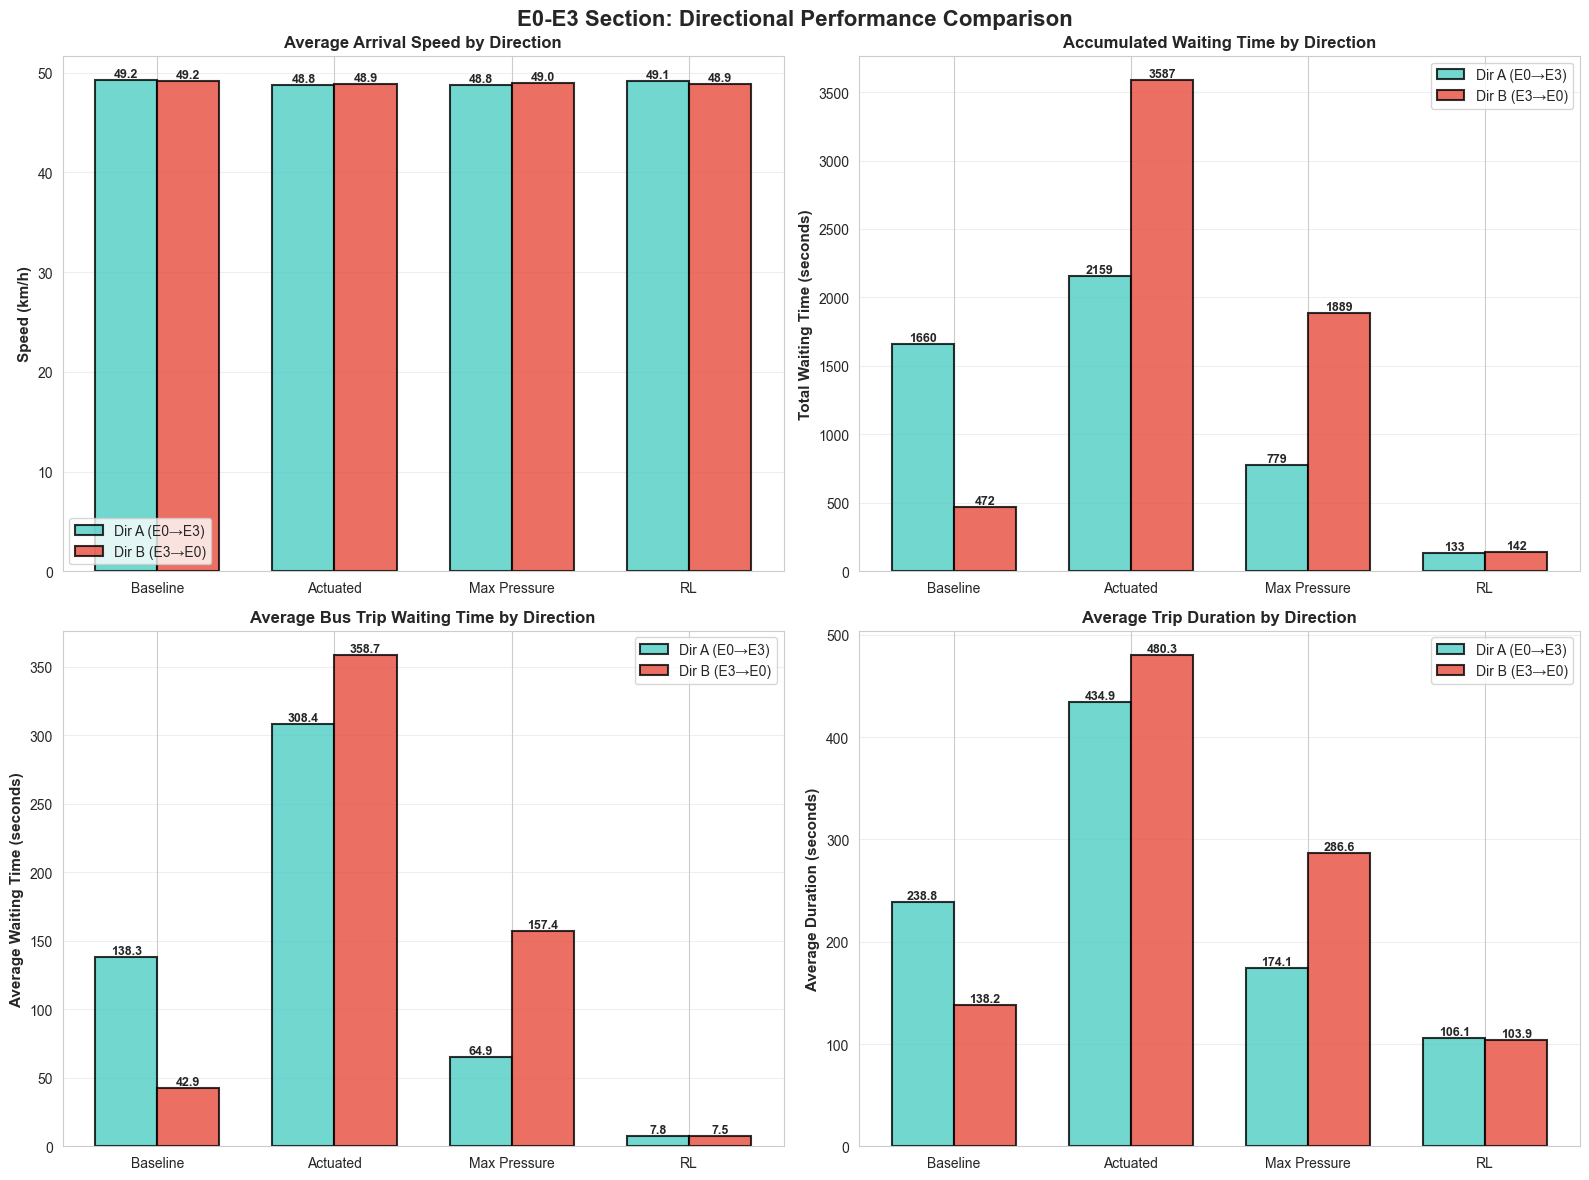

In [6]:
# Create directional performance comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('E0-E3 Section: Directional Performance Comparison', fontsize=16, fontweight='bold')

scenarios = summary_df.index
colors_a = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
colors_b = ['#E74C3C', '#16A085', '#2980B9', '#27AE60']

x = np.arange(len(scenarios))
width = 0.35

# 1. Average Speed by Direction
ax = axes[0, 0]
speed_a = summary_df['Dir A Speed (km/h)']
speed_b = summary_df['Dir B Speed (km/h)']
bars1 = ax.bar(x - width/2, speed_a, width, label='Dir A (E0→E3)', color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, speed_b, width, label='Dir B (E3→E0)', color='#E74C3C', alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Speed (km/h)', fontsize=11, fontweight='bold')
ax.set_title('Average Arrival Speed by Direction', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 2. Accumulated Waiting Time by Direction
ax = axes[0, 1]
wait_a = summary_df['Dir A Total Wait (s)']
wait_b = summary_df['Dir B Total Wait (s)']
bars1 = ax.bar(x - width/2, wait_a, width, label='Dir A (E0→E3)', color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, wait_b, width, label='Dir B (E3→E0)', color='#E74C3C', alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Total Waiting Time (seconds)', fontsize=11, fontweight='bold')
ax.set_title('Accumulated Waiting Time by Direction', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 3. Average Bus Trip Waiting Time by Direction
ax = axes[1, 0]
bus_wait_a = summary_df['Dir A Bus Avg Wait (s)']
bus_wait_b = summary_df['Dir B Bus Avg Wait (s)']
bars1 = ax.bar(x - width/2, bus_wait_a, width, label='Dir A (E0→E3)', color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, bus_wait_b, width, label='Dir B (E3→E0)', color='#E74C3C', alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Average Waiting Time (seconds)', fontsize=11, fontweight='bold')
ax.set_title('Average Bus Trip Waiting Time by Direction', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 4. Average Trip Duration by Direction
ax = axes[1, 1]
dur_a = summary_df['Dir A Avg Duration (s)']
dur_b = summary_df['Dir B Avg Duration (s)']
bars1 = ax.bar(x - width/2, dur_a, width, label='Dir A (E0→E3)', color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, dur_b, width, label='Dir B (E3→E0)', color='#E74C3C', alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Average Duration (seconds)', fontsize=11, fontweight='bold')
ax.set_title('Average Trip Duration by Direction', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()

# Save figure
directional_plot = os.path.join(OUTPUT_DIR, 'directional_performance_comparison.png')
plt.savefig(directional_plot, dpi=300, bbox_inches='tight')
print(f"✓ Directional performance comparison saved to: {directional_plot}")
plt.show()

## 5. Bus Performance Analysis

✓ Bus performance comparison saved to: c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Scenario comparison results\bus_performance_comparison.png

BUS PERFORMANCE STATISTICS

Baseline:
  Direction A (E0→E3):
    - Avg Waiting Time:   138.33 seconds
    - Avg Duration:       238.75 seconds
  Direction B (E3→E0):
    - Avg Waiting Time:    42.91 seconds
    - Avg Duration:       138.18 seconds

Actuated:
  Direction A (E0→E3):
    - Avg Waiting Time:   308.43 seconds
    - Avg Duration:       434.86 seconds
  Direction B (E3→E0):
    - Avg Waiting Time:   358.70 seconds
    - Avg Duration:       480.30 seconds

Max Pressure:
  Direction A (E0→E3):
    - Avg Waiting Time:    64.92 seconds
    - Avg Duration:       174.08 seconds
  Direction B (E3→E0):
    - Avg Waiting Time:   157.42 seconds
    - Avg Duration:       286.58 seconds

RL:
  Direction A (E0→E3):
    - Avg Waiting Tim

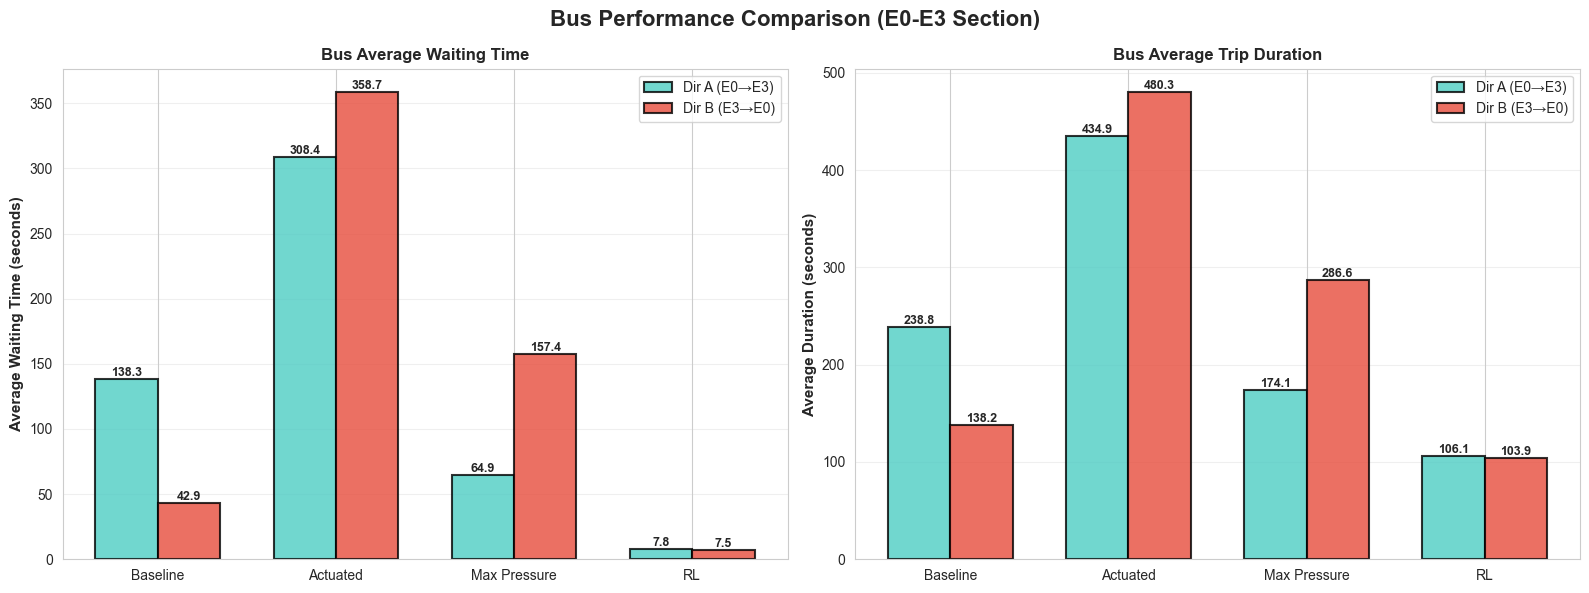

In [7]:
# Create bus-specific comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Bus Performance Comparison (E0-E3 Section)', fontsize=16, fontweight='bold')

scenarios = summary_df.index
x = np.arange(len(scenarios))
width = 0.35

# 1. Bus Waiting Time
ax = axes[0]
bus_wait_a = summary_df['Dir A Bus Avg Wait (s)']
bus_wait_b = summary_df['Dir B Bus Avg Wait (s)']
bars1 = ax.bar(x - width/2, bus_wait_a, width, label='Dir A (E0→E3)', color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, bus_wait_b, width, label='Dir B (E3→E0)', color='#E74C3C', alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Average Waiting Time (seconds)', fontsize=11, fontweight='bold')
ax.set_title('Bus Average Waiting Time', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 2. Bus Trip Duration
ax = axes[1]
bus_dur_a = summary_df['Dir A Bus Avg Duration (s)']
bus_dur_b = summary_df['Dir B Bus Avg Duration (s)']
bars1 = ax.bar(x - width/2, bus_dur_a, width, label='Dir A (E0→E3)', color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, bus_dur_b, width, label='Dir B (E3→E0)', color='#E74C3C', alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Average Duration (seconds)', fontsize=11, fontweight='bold')
ax.set_title('Bus Average Trip Duration', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()

# Save figure
bus_plot = os.path.join(OUTPUT_DIR, 'bus_performance_comparison.png')
plt.savefig(bus_plot, dpi=300, bbox_inches='tight')
print(f"✓ Bus performance comparison saved to: {bus_plot}")

# Print bus statistics
print("\n" + "="*80)
print("BUS PERFORMANCE STATISTICS")
print("="*80)
for scenario in scenarios:
    print(f"\n{scenario}:")
    print(f"  Direction A (E0→E3):")
    print(f"    - Avg Waiting Time: {summary_df.loc[scenario, 'Dir A Bus Avg Wait (s)']:8.2f} seconds")
    print(f"    - Avg Duration:     {summary_df.loc[scenario, 'Dir A Bus Avg Duration (s)']:8.2f} seconds")
    print(f"  Direction B (E3→E0):")
    print(f"    - Avg Waiting Time: {summary_df.loc[scenario, 'Dir B Bus Avg Wait (s)']:8.2f} seconds")
    print(f"    - Avg Duration:     {summary_df.loc[scenario, 'Dir B Bus Avg Duration (s)']:8.2f} seconds")
print("="*80)

plt.show()

## 6. Performance Improvements vs Baseline (Directional)


IMPROVEMENT vs BASELINE (Directional)
              Dir A Wait Improvement (%)  Dir B Wait Improvement (%)  Dir A Speed Improvement (%)  Dir B Speed Improvement (%)
Scenario                                                                                                                      
Actuated                          -30.06                     -659.96                        -0.97                        -0.60
Max Pressure                       53.07                     -300.21                        -0.96                        -0.49
RL                                 91.99                       69.92                        -0.23                        -0.64

✓ Improvements saved to: c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Scenario comparison results\improvements_vs_baseline_directional.csv
✓ Improvement plot saved to: c:\Users\antoi\OneDrive\Documents\Documents\

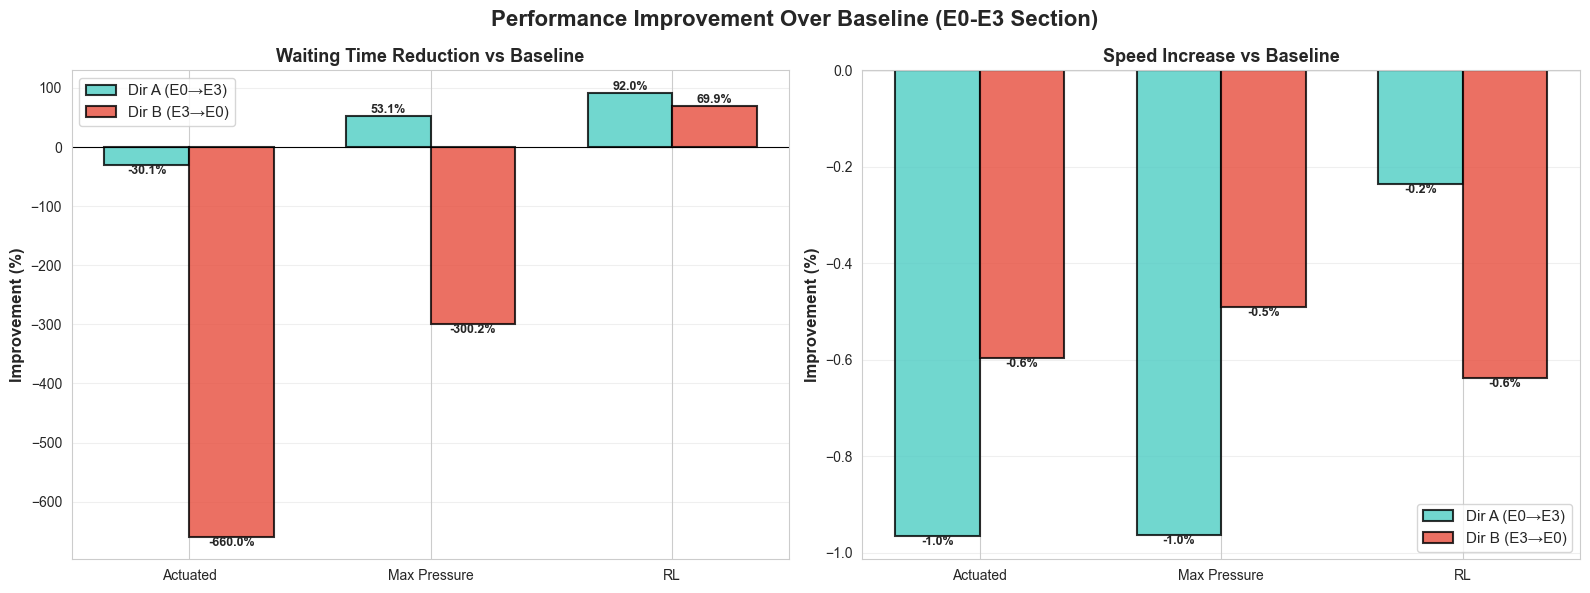

In [8]:
# Calculate improvements vs baseline for directional metrics
baseline_dir_a_wait = summary_df.loc['Baseline', 'Dir A Total Wait (s)']
baseline_dir_b_wait = summary_df.loc['Baseline', 'Dir B Total Wait (s)']
baseline_dir_a_speed = summary_df.loc['Baseline', 'Dir A Speed (km/h)']
baseline_dir_b_speed = summary_df.loc['Baseline', 'Dir B Speed (km/h)']

improvements = []
for scenario in summary_df.index:
    if scenario != 'Baseline':
        dir_a_wait = summary_df.loc[scenario, 'Dir A Total Wait (s)']
        dir_b_wait = summary_df.loc[scenario, 'Dir B Total Wait (s)']
        dir_a_speed = summary_df.loc[scenario, 'Dir A Speed (km/h)']
        dir_b_speed = summary_df.loc[scenario, 'Dir B Speed (km/h)']
        
        wait_a_improvement = ((baseline_dir_a_wait - dir_a_wait) / baseline_dir_a_wait) * 100
        wait_b_improvement = ((baseline_dir_b_wait - dir_b_wait) / baseline_dir_b_wait) * 100
        speed_a_improvement = ((dir_a_speed - baseline_dir_a_speed) / baseline_dir_a_speed) * 100
        speed_b_improvement = ((dir_b_speed - baseline_dir_b_speed) / baseline_dir_b_speed) * 100
        
        improvements.append({
            'Scenario': scenario,
            'Dir A Wait Improvement (%)': wait_a_improvement,
            'Dir B Wait Improvement (%)': wait_b_improvement,
            'Dir A Speed Improvement (%)': speed_a_improvement,
            'Dir B Speed Improvement (%)': speed_b_improvement,
        })

improvement_df = pd.DataFrame(improvements).set_index('Scenario')

# Save improvements to CSV
improvement_csv = os.path.join(OUTPUT_DIR, 'improvements_vs_baseline_directional.csv')
improvement_df.to_csv(improvement_csv)

print("\n" + "="*80)
print("IMPROVEMENT vs BASELINE (Directional)")
print("="*80)
print(improvement_df.round(2).to_string())
print("="*80)
print(f"\n✓ Improvements saved to: {improvement_csv}")

# Visualization of improvements
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Performance Improvement Over Baseline (E0-E3 Section)', fontsize=16, fontweight='bold')

x = np.arange(len(improvement_df.index))
width = 0.35

# Waiting time improvements
ax = axes[0]
bars1 = ax.bar(x - width/2, improvement_df['Dir A Wait Improvement (%)'], 
               width, label='Dir A (E0→E3)', color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, improvement_df['Dir B Wait Improvement (%)'], 
               width, label='Dir B (E3→E0)', color='#E74C3C', alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Improvement (%)', fontsize=12, fontweight='bold')
ax.set_title('Waiting Time Reduction vs Baseline', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(improvement_df.index)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold', fontsize=9)

# Speed improvements
ax = axes[1]
bars1 = ax.bar(x - width/2, improvement_df['Dir A Speed Improvement (%)'], 
               width, label='Dir A (E0→E3)', color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, improvement_df['Dir B Speed Improvement (%)'], 
               width, label='Dir B (E3→E0)', color='#E74C3C', alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Improvement (%)', fontsize=12, fontweight='bold')
ax.set_title('Speed Increase vs Baseline', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(improvement_df.index)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold', fontsize=9)

plt.tight_layout()

# Save figure
improvement_plot = os.path.join(OUTPUT_DIR, 'improvements_vs_baseline_directional.png')
plt.savefig(improvement_plot, dpi=300, bbox_inches='tight')
print(f"✓ Improvement plot saved to: {improvement_plot}")
plt.show()

## 7. Scenario Rankings (Directional Metrics)

In [9]:
# Create rankings for directional metrics
rankings_output = []
rankings_output.append("\n" + "="*80)
rankings_output.append("SCENARIO RANKINGS - E0-E3 SECTION (DIRECTIONAL)")
rankings_output.append("="*80)

# Direction A - Speed ranking (higher is better)
rankings_output.append("\n1. DIRECTION A (E0→E3) - AVERAGE SPEED (Higher is Better)")
rankings_output.append("-" * 80)
for i, (scenario, speed) in enumerate(summary_df['Dir A Speed (km/h)'].sort_values(ascending=False).items(), 1):
    rankings_output.append(f"   {i}. {scenario:20s} {speed:8.2f} km/h")

# Direction B - Speed ranking (higher is better)
rankings_output.append("\n2. DIRECTION B (E3→E0) - AVERAGE SPEED (Higher is Better)")
rankings_output.append("-" * 80)
for i, (scenario, speed) in enumerate(summary_df['Dir B Speed (km/h)'].sort_values(ascending=False).items(), 1):
    rankings_output.append(f"   {i}. {scenario:20s} {speed:8.2f} km/h")

# Direction A - Total waiting time (lower is better)
rankings_output.append("\n3. DIRECTION A (E0→E3) - ACCUMULATED WAITING TIME (Lower is Better)")
rankings_output.append("-" * 80)
for i, (scenario, wait) in enumerate(summary_df['Dir A Total Wait (s)'].sort_values().items(), 1):
    rankings_output.append(f"   {i}. {scenario:20s} {wait:8.0f} seconds")

# Direction B - Total waiting time (lower is better)
rankings_output.append("\n4. DIRECTION B (E3→E0) - ACCUMULATED WAITING TIME (Lower is Better)")
rankings_output.append("-" * 80)
for i, (scenario, wait) in enumerate(summary_df['Dir B Total Wait (s)'].sort_values().items(), 1):
    rankings_output.append(f"   {i}. {scenario:20s} {wait:8.0f} seconds")

# Direction A - Bus waiting time (lower is better)
rankings_output.append("\n5. DIRECTION A (E0→E3) - BUS AVERAGE WAITING TIME (Lower is Better)")
rankings_output.append("-" * 80)
for i, (scenario, wait) in enumerate(summary_df['Dir A Bus Avg Wait (s)'].sort_values().items(), 1):
    rankings_output.append(f"   {i}. {scenario:20s} {wait:8.2f} seconds")

# Direction B - Bus waiting time (lower is better)
rankings_output.append("\n6. DIRECTION B (E3→E0) - BUS AVERAGE WAITING TIME (Lower is Better)")
rankings_output.append("-" * 80)
for i, (scenario, wait) in enumerate(summary_df['Dir B Bus Avg Wait (s)'].sort_values().items(), 1):
    rankings_output.append(f"   {i}. {scenario:20s} {wait:8.2f} seconds")

# Direction A - Average duration (lower is better)
rankings_output.append("\n7. DIRECTION A (E0→E3) - AVERAGE TRIP DURATION (Lower is Better)")
rankings_output.append("-" * 80)
for i, (scenario, dur) in enumerate(summary_df['Dir A Avg Duration (s)'].sort_values().items(), 1):
    rankings_output.append(f"   {i}. {scenario:20s} {dur:8.2f} seconds")

# Direction B - Average duration (lower is better)
rankings_output.append("\n8. DIRECTION B (E3→E0) - AVERAGE TRIP DURATION (Lower is Better)")
rankings_output.append("-" * 80)
for i, (scenario, dur) in enumerate(summary_df['Dir B Avg Duration (s)'].sort_values().items(), 1):
    rankings_output.append(f"   {i}. {scenario:20s} {dur:8.2f} seconds")

rankings_output.append("=" * 80)

# Print rankings
for line in rankings_output:
    print(line)

# Save rankings to text file
rankings_file = os.path.join(OUTPUT_DIR, 'scenario_rankings_directional.txt')
with open(rankings_file, 'w') as f:
    f.write('\n'.join(rankings_output))
print(f"\n✓ Rankings saved to: {rankings_file}")


SCENARIO RANKINGS - E0-E3 SECTION (DIRECTIONAL)

1. DIRECTION A (E0→E3) - AVERAGE SPEED (Higher is Better)
--------------------------------------------------------------------------------
   1. Baseline                49.25 km/h
   2. RL                      49.13 km/h
   3. Max Pressure            48.77 km/h
   4. Actuated                48.77 km/h

2. DIRECTION B (E3→E0) - AVERAGE SPEED (Higher is Better)
--------------------------------------------------------------------------------
   1. Baseline                49.20 km/h
   2. Max Pressure            48.95 km/h
   3. Actuated                48.90 km/h
   4. RL                      48.88 km/h

3. DIRECTION A (E0→E3) - ACCUMULATED WAITING TIME (Lower is Better)
--------------------------------------------------------------------------------
   1. RL                        133 seconds
   2. Max Pressure              779 seconds
   3. Baseline                 1660 seconds
   4. Actuated                 2159 seconds

4. DIRECTION B (